In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rpy2.robjects as ro
from functools import partial
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.ipython import html
html.html_rdataframe = partial(html.html_rdataframe, table_class = "docutils")
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [92]:
%%R
library(mlbench)
datasetxor <- mlbench.xor(300)
XR_datasetxor <- datasetxor$x
LABELSR_datasetxor<- datasetxor$classes

In [93]:
from rpy2.robjects import numpy2ri
numpy2ri.activate()
x_df_xor = np.array(ro.r['XR_datasetxor'])
labels_df_xor = np.array(ro.r['LABELSR_datasetxor'])
labels_df_xor[labels_df_xor == 1] = -1
labels_df_xor[labels_df_xor == 2] = 1

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_df_xor, labels_df_xor, random_state = 0, train_size = 0.7)

In [95]:
from sklearn.preprocessing import StandardScaler
def train_ELM_DropOut(xin : np.ndarray, yin : np.ndarray, p : int, keep_rate : float, control : bool) -> list:
    np.random.seed(np.random.randint(0, 10000))

    n = xin.shape[1] # Pegando o número de valores de cada entrada.

    # Z[n ou n + 1, p]
    if control == True:
        Z = np.array([np.random.uniform(-0.5, 0.5) for _ in range((n + 1) * p)]).reshape(n + 1, p)
        #Z = np.array(100*np.random.random((n + 1)*p).reshape(n + 1, p))
        ones = np.ones((xin.shape[0], 1))
        xin = np.concatenate((xin,ones), axis = 1)
    else:
        Z = np.array([np.random.uniform(-0.5, 0.5) for _ in range(n * p)]).reshape(n , p)
        #Z = np.array(100*np.random.random(n *p).reshape(n, p))

    
    H = np.tanh(np.dot(xin, Z))
    #print(f"H ANTES : {H[: 2,: 2]}")
    scaler = StandardScaler()
    H = scaler.fit_transform(H)
    #print(f"H DEPOIS: {H[: 2,: 2]}")

    
    ones = np.ones((H.shape[0], 1))
    H = np.concatenate((H, ones), axis = 1)

    w = np.dot(np.linalg.pinv(H), yin) # w = H⁺y
    try:
        N_col_W = w.shape[1]
    except Exception as error:
        if type(error) == IndexError:
            #print(f" You don't have the necessary dimensions, so we will reshape your matrix w !")
            w = w.reshape(-1, 1)
            N_col_W = w.shape[1]

    
    for i in range(N_col_W): # Removendo os pesos menos relevantes da camada de saída.
        N_dropped_neurons = int(np.ceil((1 - keep_rate) * w[:, i].shape[0])) # Pegando o número de neurônios que serão dropados.
        idx = np.array(np.argsort(np.abs(w[:, i]))) # Pegandos os índices dos neurônios que serão dropados.
        lowest_val = idx[:N_dropped_neurons]
        for j in lowest_val: # Zerando os pesos menos relevantes.
            w[j, i] = 0


    return_list = list()
    return_list.append(w)   
    return_list.append(H)
    return_list.append(Z) # Conexões são desligadas apenas no treino, portanto tenho que mandar a matriz Z completa.
    return  return_list


def test_ELM(xin: np.ndarray, Z: np.ndarray, W: np.ndarray, control: bool):
    
    if control == True:
        ones = np.ones((xin.shape[0], 1))
        xin = np.concatenate((xin, ones), axis = 1)
        
    H = np.tanh(np.dot(xin, Z))
    ones = np.ones((H.shape[0], 1))
    H = np.concatenate((H, ones), axis = 1)
    
    Y_hat = np.sign(np.dot(H, W)) # Para problemas de classificação.
    #Y_hat = np.dot(H, W) # Para problemas de regressão.
    return Y_hat



In [96]:
%%time
p_neurons = 50
ret = train_ELM_DropOut(xin = X_train, yin = y_train, p = p_neurons, keep_rate = 0.8, control = True)
wxor = ret[0]
hxor = ret[1]
zxor = ret[2]

CPU times: user 10 ms, sys: 44.2 ms, total: 54.3 ms
Wall time: 11.1 ms


In [104]:
from sklearn.metrics import accuracy_score

best_acc = 0
i = 0.1
while i < 1:
    train_ELM_DropOut(xin = X_train, yin = y_train, p = p_neurons, keep_rate = i, control = True)
    wxor = ret[0]
    hxor = ret[1]
    zxor = ret[2]
    y_net = test_ELM(xin = X_test,W = wxor, Z = zxor, control = True)
    accuracy_test = accuracy_score(y_test, y_net)
    
    if accuracy_test > best_acc:
        best_keep_rate = i
        best_acc = accuracy_test
        best_w = wxor
        best_z = zxor
        best_h = hxor
        best_out = y_net
    print(f"i : {i}, acc : {accuracy_test}")

    i = i + 0.01



    

i : 0.1, acc : 0.4111111111111111
i : 0.11, acc : 0.4111111111111111
i : 0.12, acc : 0.4111111111111111
i : 0.13, acc : 0.4111111111111111
i : 0.14, acc : 0.4111111111111111
i : 0.15000000000000002, acc : 0.4111111111111111
i : 0.16000000000000003, acc : 0.4111111111111111
i : 0.17000000000000004, acc : 0.4111111111111111
i : 0.18000000000000005, acc : 0.4111111111111111
i : 0.19000000000000006, acc : 0.4111111111111111
i : 0.20000000000000007, acc : 0.4111111111111111
i : 0.21000000000000008, acc : 0.4111111111111111
i : 0.22000000000000008, acc : 0.4111111111111111
i : 0.2300000000000001, acc : 0.4111111111111111
i : 0.2400000000000001, acc : 0.4111111111111111
i : 0.2500000000000001, acc : 0.4111111111111111
i : 0.2600000000000001, acc : 0.4111111111111111
i : 0.27000000000000013, acc : 0.4111111111111111
i : 0.28000000000000014, acc : 0.4111111111111111
i : 0.29000000000000015, acc : 0.4111111111111111
i : 0.30000000000000016, acc : 0.4111111111111111
i : 0.31000000000000016, acc :

In [98]:
print(f" The best val of i : {best_keep_rate}")

 The best val of i : 0.1


In [99]:
labels_df_reshaped = labels_df_xor.reshape(-1, 1)
mat_plot = np.concatenate((x_df_xor, labels_df_reshaped), axis = 1)
index_sort = 2
sorted_indices = np.argsort(mat_plot[:, index_sort])
mat_plot = mat_plot[sorted_indices]

[]

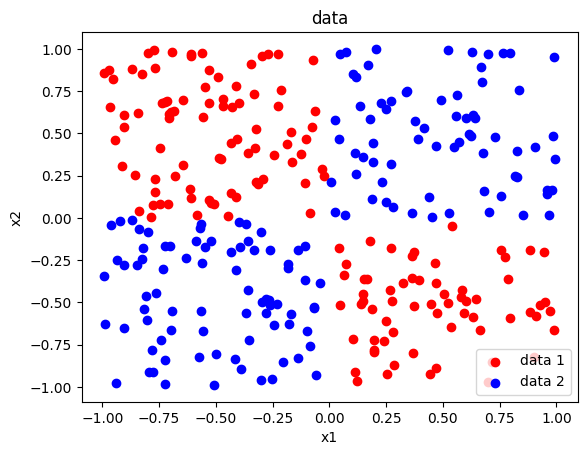

In [100]:
x1_points = mat_plot[: 150, 0 : 2]
x2_points = mat_plot[150 :, 0 : 2]
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data 1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data 2')
plt.title('data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.plot()

/tmp/ipykernel_270516/2562079984.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  MZ[i, j] = np.sign(np.dot(best_h, best_w))[0]


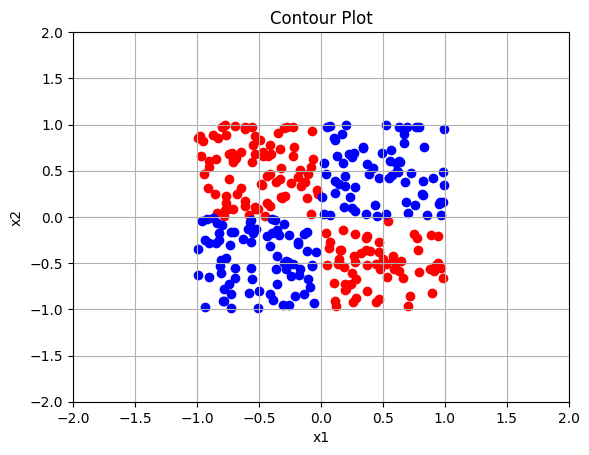

In [101]:
seqx1x2 = np.linspace(start = -4, stop = 4, num = 300)
np_grid = seqx1x2.shape[0]
shape = (np_grid, np_grid)
MZ = np.zeros(shape)
for i in range(np_grid):
    for j in range(np_grid):
        x1 = seqx1x2[i]
        x2 = seqx1x2[j]
        x1x2 = np.column_stack((x1, x2, 1))
        h1 = np.tanh(np.dot(x1x2, best_z))
        h1 = np.column_stack((best_h, np.ones_like(best_h[:, 0])))
        MZ[i, j] = np.sign(np.dot(best_h, best_w))[0]


plt.contour(seqx1x2, seqx1x2, MZ, levels = 1)
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

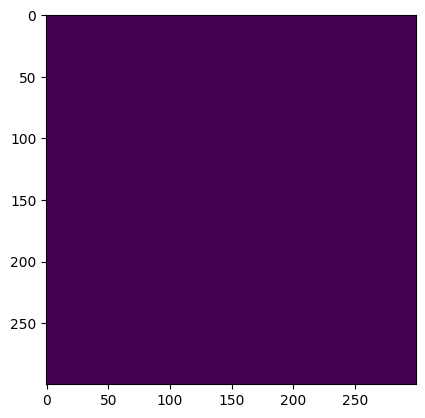

In [102]:
plt.imshow(MZ)